### Do your imports!

In [ ]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

# 311 data analysis

## Read in `subset.csv` and review the first few rows

Even though it's a giant file – gigs and gigs! – it's a subset of the [entire dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9). It covers plenty of years, but not all of the columns.

If your computer is struggling (which it will!) or you are impatient, feel free to use `nrows=` when reading it in to speed up the process by only reading in a subset of columns. Pull in at least a few million, or a couple years back.

In [ ]:
df = pd.read_csv('subset.csv')

In [62]:
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,time_to_fix
0,41694420,2019-01-27 19:26:21,2019-02-13 10:53:25,HPD,Department of Housing Preservation and Develop...,GENERAL,BELL/BUZZER/INTERCOM,RESIDENTIAL BUILDING,11216,30 MAC DONOUGH STREET,ADDRESS,BROOKLYN,Closed,BROOKLYN,PHONE,16 days 15:27:04
1,41694421,2019-01-29 11:06:56,2019-02-13 02:07:22,HPD,Department of Housing Preservation and Develop...,PAINT/PLASTER,CEILING,RESIDENTIAL BUILDING,10453,30 RICHMAN PLAZA,ADDRESS,BRONX,Closed,BRONX,PHONE,14 days 15:00:26
2,41694422,2019-02-13 12:28:18,2019-03-15 09:54:50,DOF,External Affairs Unit,DOF Property - Payment Issue,Bill Received in Error,Property Address,11412,120-25 200 STREET,ADDRESS,SAINT ALBANS,Closed,QUEENS,PHONE,29 days 21:26:32
3,41694423,2019-02-13 15:40:19,2019-02-20 06:18:35,DOT,Department of Transportation,Broken Parking Meter,Out of Order,Street,11377,NaN,INTERSECTION,WOODSIDE,Closed,QUEENS,PHONE,6 days 14:38:16
4,41694424,2019-02-13 13:18:31,2019-02-20 05:36:54,DOT,Department of Transportation,Broken Parking Meter,Out of Order,Street,10461,1082 MORRIS PARK AVENUE,ADDRESS,BRONX,Closed,BRONX,PHONE,6 days 16:18:23


### Where the subset came from

If you're curious, I took the [original data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data) and clipped out a subset by using the command-line tool [csvkit](https://csvkit.readthedocs.io/en/latest/).

First I inspected the column headers:

```bash
$ csvcut -n 311_Service_Requests_from_2010_to_Present.csv 
```

Then I selected the columns I was interested in and saved it to a file.

```bash
$ csvcut -c 1,2,3,4,5,6,7,8,9,10,16,17,20,26,29 311_Service_Requests_from_2010_to_Present.csv > subset.csv
```

This was much much much much faster than doing it in Python.

## We hate those column names!

Change the column names to be tab- and period-friendly, like `df.created_date` instead of `df['Created Date']`

In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Dates and times

## Are the datetimes actually datetimes?

We're going to be doing some datetime-y things, so let's see if the columns that look like dates are actually dates.

In [63]:
df.dtypes

unique_key                          int64
created_date               datetime64[ns]
closed_date                datetime64[ns]
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
location_type                      object
incident_zip                       object
incident_address                   object
address_type                       object
city                               object
status                             object
borough                            object
open_data_channel_type             object
time_to_fix               timedelta64[ns]
dtype: object

## In they aren't datetimes, convert them

The ones we're interested in are as follows:

* Created Date
* Closed Date

You have two options to convert them:

1. Do it like we did in class, but **overwrite the existing string columns with the new datetime versions**
2. Find an option with `read_csv` to automatically read certain columns as dates! Use the shift+tab trick to read the `read_csv` docs to uncover it. Once you find it, you'll set it to be the **list of date-y columns**.

They're both going to take forever if you do them wrong, but can be faster with a few tricks. For example, using `pd.to_datetime` can be sped up significantly be specifying the format of the datestring.

For example, if your datetime was formatted as `YYYY-MM-DD HH:MM:SS AM`, you could use the following:

```
df.my_datetime = pd.to_datetime(df.my_datetime, format="%Y-%m-%d %I:%M:%S %p")
```

It's unfortunately much much much faster than the `read_csv` technique. And yes, [that's `%I` and not `%H`](https://strftime.org/).

> *Tip: What should happen if it encounters an error or missing data?*

In [ ]:
df.closed_date = pd.to_datetime(df.closed_date, format="%m/%d/%Y %I:%M:%S %p", errors='coerce')
df.created_date = pd.to_datetime(df.created_date, format="%m/%d/%Y %I:%M:%S %p", errors='coerce')
df.head()

## According to the dataset, which month of the year has the most 311 calls?

The kind of answer we're looking for is "January," not "January 2021"

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

In [64]:
# I chose dt.month because it would pull out just the numberic value for the month
# (and not the year which would complicate things)
# Then I did a value count to see number of repetition of the month values.
# Most calls were June.
df.created_date.dt.month.value_counts().sort_values(ascending=False)

6     2446844
1     2390046
10    2368502
8     2330055
7     2323116
5     2309849
3     2279327
9     2268179
11    2165684
4     2110931
2     2087482
12    2018866
Name: created_date, dtype: int64

## Plot the 311 call frequency over our dataset on a _weekly_ basis

To make your y axis start at zero, use `ylim=(0,100000)` when doing `.plot`. But replace the `1000` with a large enough value to actually see your data nicely!

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

<AxesSubplot:xlabel='created_date'>

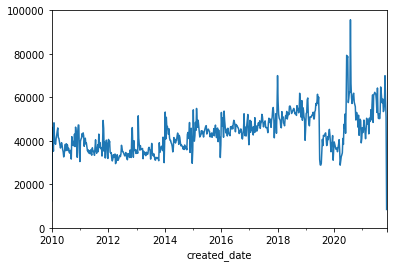

In [65]:
# Used resample and size which adds up for me the number of records that occur during a week
# Leaving the ylim max at 100000 because it looks good to me
df.resample("W", on="created_date").size() \
    .plot(ylim=[0,100000])

## What time of day (by hour) is the least common for 311 complains? The most common?


In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

In [69]:
# Pulled out the hour ALONE by using dt. 
# Resample would give me date hour by day and that's too much data.
# Did a value counts to get number of repetitions of the hour value
# Most were created at midnight, which could be because 00:00:00 might be being used as a NA value
df.created_date.dt.hour.value_counts().head()

0     4417910
12    1717217
11    1625022
10    1618244
14    1480009
Name: created_date, dtype: int64

In [70]:
# Least common time of day was 4 a.m.
df.created_date.dt.hour.value_counts().tail()

2    362348
6    356715
3    242543
5    206896
4    197293
Name: created_date, dtype: int64

### Make a graph of the results

* Make sure the hours are in the correct order
* Be sure to set the y-axis to start at 0
* Give your plot a descriptive title

<AxesSubplot:title={'center':'311 calls by hour of the day'}>

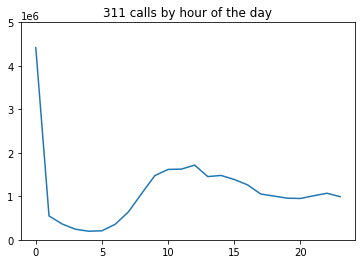

In [67]:
df.created_date.dt.hour.value_counts() \
    .sort_index() \
    .plot(ylim=[0, 5000000],title ="311 calls by hour of the day")

# Agencies

## What agencies field the most complaints in the dataset? Get the top 5.

Use the `agency` column for this one.

In [68]:
# Get the agency column
# Do a value_counts()
df.agency.value_counts().head()

NYPD    7714187
HPD     6762860
DOT     3468756
DSNY    2189273
DEP     2003413
Name: agency, dtype: int64

## What are each of those agencies?

Define the following five acronyms:

* NYPD
* HPD
* DOT
* DSNY
* DEP

In [ ]:
# NYPD: New York Police Department
# HPD: Department of Housing Preservation and Development
# DOT: Department of Transportation
# DSNY: Department of Sanitation
# DEP: Department of Environmental Protection

## What is the most common complaint to HPD?

In [ ]:
# Why did you pick these columns to calculate the answer?

In [58]:
# Complaint type will give me a generic complaint. 
# The descriptor will give me more detail. They might also vary more.
# I'm interested in the broader category for now.
# Filtering the data to only include Agency == HPD
# Doing a value count on the complaint type
# Most complaints deal with heating and hot water.
df[df.agency == 'HPD'].complaint_type.value_counts().head()

HEAT/HOT WATER          1545205
HEATING                  887869
PLUMBING                 777856
UNSANITARY CONDITION     565403
GENERAL CONSTRUCTION     500863
Name: complaint_type, dtype: int64

## What are the top 3 complaints to each agency?

You'll want to use the weird confusing `.groupby(level=...` thing we learned when reviewing the homework.

In [13]:
pd.reset_option("display.max_rows")
df.groupby('agency').complaint_type.value_counts().groupby(level=0, group_keys=False).nlargest(3)

agency  complaint_type                
3-1-1   Noise Survey                       16301
        City Vehicle Placard Complaint      2393
        OEM Disabled Vehicle                1872
ACS     Forms                               1219
        Damaged Tree                           1
                                           ...  
TAX     Question                             430
        Comments                              31
TLC     Taxi Complaint                    176656
        For Hire Vehicle Complaint         76643
        Lost Property                      14850
Name: complaint_type, Length: 74, dtype: int64

## What is the most common kind of residential noise complaint?

The NYPD seems to deal with a lot of noise complaints at homes. What is the most common subtype?

In [ ]:
# Why did you pick these columns to calculate the answer?

In [14]:
# I looked at the complaint_type column to see which broader categories existed. 
# They didn't seem particularly specific, so I decided to look at the descriptor column to get more info
df[df.complaint_type.str.contains("noise", case=False, na=False)].complaint_type.value_counts()

Noise - Residential         2546181
Noise - Street/Sidewalk      856597
Noise                        560327
Noise - Commercial           441371
Noise - Vehicle              377572
Noise - Park                  51830
Noise - Helicopter            44543
Noise Survey                  16303
Noise - House of Worship      12342
Collection Truck Noise         1709
Name: complaint_type, dtype: int64

In [59]:
# I searched the descriptor column for the word noise 
# and found it interesting that specifically construction noise is a big issue.
# See Construction Before/After hours, Construction Equipment and Jack Hammering
df[df.descriptor.str.contains("noise", case=False,na=False)].descriptor.value_counts().head()

Noise: Construction Before/After Hours (NM1)        230049
Noise, Barking Dog (NR5)                             78177
Noise: Construction Equipment (NC1)                  77869
Noise: air condition/ventilation equipment (NV1)     41754
Noise: Alarms (NR3)                                  38311
Name: descriptor, dtype: int64

## What time of day do "Loud Music/Party" complaints come in? Make it a chart!

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

In [16]:
#Find the Loud Music/Party descriptor
df[df.descriptor == "Loud Music/Party"].head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type
39,41694463,2019-02-13 22:47:39,2019-02-14 00:14:52,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10025,229 WEST 109 STREET,ADDRESS,NEW YORK,Closed,MANHATTAN,PHONE
40,41694464,2019-02-13 23:57:15,2019-02-14 05:36:55,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11354,144-25 ROOSEVELT AVENUE,ADDRESS,FLUSHING,Closed,QUEENS,PHONE
42,41694466,2019-02-13 23:01:38,2019-02-14 00:43:10,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11215,644 PRESIDENT STREET,ADDRESS,BROOKLYN,Closed,BROOKLYN,MOBILE
58,41694484,2019-02-13 19:04:35,2019-02-14 01:33:51,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,10013,221 CENTRE STREET,ADDRESS,NEW YORK,Closed,MANHATTAN,MOBILE
60,41694486,2019-02-13 20:24:57,2019-02-13 20:31:17,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,11233,93 HOWARD AVENUE,ADDRESS,BROOKLYN,Closed,BROOKLYN,MOBILE


In [60]:
# Take filtered df
# Get the hour using dt, because I'm only interested in the hour value not the date
# Count repetition of the hour values
# Most complaints come in from 10pm - Midnight
df[df.descriptor == "Loud Music/Party"].created_date.dt.hour.value_counts().sort_values(ascending=False).head()

23    382646
22    345722
0     322377
21    243378
1     236091
Name: created_date, dtype: int64

<AxesSubplot:>

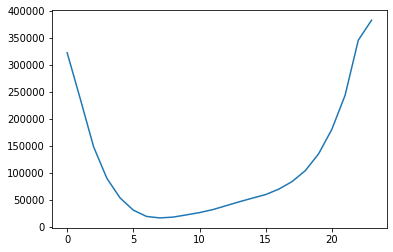

In [18]:
df[df.descriptor == "Loud Music/Party"].created_date.dt.hour.value_counts().sort_index().plot()

## When do people party hard?

Make a monthly chart of Loud Music/Party complaints since the beginning of the dataset. Make it count them on a biweekly basis (every two weeks).

In [ ]:
# there are two big techniques for date stuff: .dt or .resample
# if you use one of those, explain why you picked that one and not the other

<AxesSubplot:xlabel='created_date'>

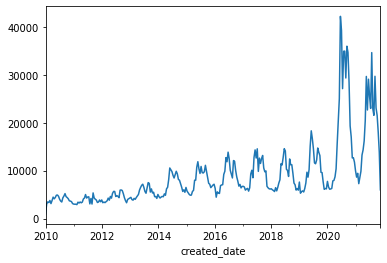

In [19]:
df[df.descriptor == "Loud Music/Party"].resample("2W", on="created_date").size().plot()

## People and their bees

Sometimes people complain about bees! Why they'd do that, I have no idea. It's somewhere in "complaint_type" – can you find all of the bee-related complaints?

In [20]:
# Search the complaint type column for mentions of 'bee'
# do a value count to see which categories exist
df[df.complaint_type.str.contains("bee", case=False, na=False)].complaint_type.value_counts()

Harboring Bees/Wasps    2293
Name: complaint_type, dtype: int64

### What month do most of the complaints happen in? I'd like to see a graph.

In [21]:
# Filter complaint type column to Harboring Bees/Wasps
# Pull out the month with dt on created date
# Do a value count to get the number of recurrences of the month value
# August has the highest number of bee related complaints

df[df.complaint_type == "Harboring Bees/Wasps"].created_date.dt.month.value_counts()

8     496
9     402
7     386
5     375
6     211
10    168
4     158
11     48
3      20
1      11
12     10
2       8
Name: created_date, dtype: int64

<AxesSubplot:>

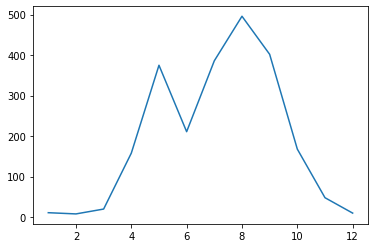

In [22]:
# Sort the index
# Plot
df[df.complaint_type == "Harboring Bees/Wasps"].created_date.dt.month.value_counts().sort_index().plot()

### Are the people getting in trouble usually beekeepers or not beekeepers?

In [23]:
# saving this filtered df to it's own variable so I can keep things straight
# searching the descriptor column for "not a" **Please note the misspelling of beekeeper in the dataset**
# doing a value_counts on the descriptor column to make sure there's no other spelling of beekeeper/beekeper
# or other descriptor with "not a" in it.
bees = df[df.complaint_type == "Harboring Bees/Wasps"]
bees[bees.descriptor.str.contains("not a", case=False, na=False)].descriptor.value_counts()

Bees/Wasps - Not a beekeper    1853
Name: descriptor, dtype: int64

In [24]:
# Now that I know what category I'm looking for I will do a value counts on the descriptor column
# To get a percentage of the total

bees.descriptor.value_counts(normalize=True, ascending=False) * 100

# ~80% of the time, non-beekeepers are getting into trouble

Bees/Wasps - Not a beekeper      80.811164
Beekeeping - Honeybees           14.958570
Bees/Wasps - Private Property     4.230266
Name: descriptor, dtype: float64

# Math with datetimes

## How long does it normally take to resolve a 311 complaint?

Even if we didn't cover this in class, I have faith that you can guess how to calculate it.

In [25]:
# Subtract the date it was closed from the date it was created
df.closed_date - df.created_date

0          16 days 15:27:04
1          14 days 15:00:26
2          29 days 21:26:32
3           6 days 14:38:16
4           6 days 16:18:23
                 ...       
27098876    1 days 06:29:00
27098877    5 days 09:22:45
27098878    2 days 04:04:31
27098879    1 days 23:55:35
27098880    2 days 00:35:21
Length: 27098881, dtype: timedelta64[ns]

Save it as a new column called `time_to_fix`

In [26]:
df['time_to_fix'] = df.closed_date - df.created_date
df.time_to_fix.median()

Timedelta('1 days 03:51:00')

## Which agency has the best time-to-fix time?

In [61]:
# Group by agency
# Get the mean time_to_fix
df.groupby(by='agency').time_to_fix.mean().sort_values(ascending=False).head()

agency
FDNY            402 days 03:27:56
DOB    77 days 08:41:26.379484144
DPR    55 days 22:50:30.444344742
DOE    55 days 06:03:34.827058376
TLC    52 days 14:44:20.909927327
Name: time_to_fix, dtype: timedelta64[ns]

In [28]:
# Mean can be deceptive because of outliers.
# Let's look at median
df.groupby(by='agency').time_to_fix.median().sort_values(ascending=False)

# OK WEEELLL This could mean a lot of things 
# IT most likely doesn't mean that these agencies respond to problems quickly
# HRA and 311 close cases in less than one minute
# Followed by EDC and NYPD which close cases in roughly an hour
# But we also have no idea how this has changed over time since the data spans from 2010 to present.

agency
TLC                                       24 days 16:37:47.500000
DOITT                                            22 days 13:04:54
DOB                                              11 days 13:00:47
DOE                                               8 days 06:01:01
NYCEM                                             6 days 23:25:00
HPD                                        5 days 23:57:56.500000
DPR                                               4 days 00:12:29
DCA                                        3 days 19:39:57.500000
DFTA                                              3 days 03:20:58
DOHMH                                             3 days 00:00:00
DOF                                               2 days 18:08:45
DSNY                                              1 days 23:38:00
DOT                                               1 days 02:00:00
DORIS                                             1 days 00:03:42
DEP                                               0 days 23:10:00
MAY

## Maybe we need some more information...

I might want to know how big our sample size is for each of those, maybe the high performers only have one or two instances of having requests filed!

### First, try using `.describe()` on the time to fix column after your `groupby`.

In [29]:
df.groupby(by='agency').time_to_fix.describe()

,count,mean,std,min,25%,50%,75%,max
agency,,,,,,,,
3-1-1,20581,0 days 00:15:07.301831786,1 days 08:17:15.516753253,0 days 00:00:02,0 days 00:00:22,0 days 00:00:40,0 days 00:00:59,192 days 23:50:16
ACS,1,0 days 22:48:06,NaT,0 days 22:48:06,0 days 22:48:06,0 days 22:48:06,0 days 22:48:06,0 days 22:48:06
CEO,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
COIB,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DCA,247466,22 days 14:34:03.526019736,72 days 05:51:16.904584621,0 days 00:03:28,1 days 02:55:59,3 days 20:12:06.500000,15 days 11:07:45,1162 days 03:16:51
DCAS,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DCP,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
DEP,1987346,8 days 03:02:31.291390628,55 days 10:05:00.954943341,-1829 days +15:05:00,0 days 02:21:00,0 days 23:33:00,4 days 16:51:00,4033 days 23:51:00
DFTA,95097,5 days 07:51:58.645446228,137 days 21:05:21.587645614,-42347 days +11:53:08,0 days 21:39:37,3 days 03:29:43,8 days 01:50:55,1506 days 10:19:19


### Now, an alternative

Seems a little busy, yeah? **You can also do smaller, custom aggregations.**

Try something like this:

```python
# Multiple aggregations of one column
df.groupby('agency').time_to_fix.agg(['median', 'size'])

# You can also do something like this to reach multiple columns
df.groupby('agency').agg({
    'time_to_fix': ['median', 'size']
})


In [30]:
df.groupby('agency').time_to_fix.agg(['median', 'size'])

,median,size
agency,,
3-1-1,0 days 00:00:40,20594
ACS,NaT,1220
CEO,NaT,5
COIB,NaT,20
DCA,3 days 19:39:57.500000,248258
DCAS,NaT,1873
DCP,NaT,89
DEP,0 days 23:10:00,2003413
DFTA,3 days 03:20:58,95231


In [31]:
df.groupby('agency').agg({
    'time_to_fix': ['median', 'size']
})

time_to_fix         
                                                         median     size
agency                                                                  
3-1-1                                           0 days 00:00:40    20594
ACS                                                         NaT     1220
CEO                                                         NaT        5
COIB                                                        NaT       20
DCA                                      3 days 19:39:57.500000   248258
DCAS                                                        NaT     1873
DCP                                                         NaT       89
DEP                                             0 days 23:10:00  2003413
DFTA                                            3 days 03:20:58    95231
DHS                                      0 days 03:36:31.500000   253402
DOB                                            11 days 13:00:47  1349868
DOE                                             8 days 06:01:01    21613
DOF                                             2 days 18:08:45   511033
DOHMH                                           3 days 00:00:00   692495
DOITT                                          22 days 13:04:54     7431
DORIS                                           1 days 00:03:42       67
DOT                                             1 days 02:00:00  3468756
DPR                                             4 days 00:12:29  1223973
DSNY                                            1 days 23:38:00  2189273
DVS                                                         NaT      123
EDC                                      0 days 01:17:44.500000    44542
FDNY                                                        NaT       61
HPD                                      5 days 23:57:56.500000  6762860
HRA                                             0 days 00:00:37   113953
MAYORâS OFFICE OF SPECIAL ENFORCEMENT         0 days 13:56:13    70673
MOC                                                         NaT        3
NYCEM                                           6 days 23:25:00     8790
NYPD                                            0 days 01:45:36  7714187
OMB                                                         NaT        2
TAT                                                         NaT       22
TAX                                                         NaT      461
TLC                                     24 days 16:37:47.500000   294590

## Seems weird that NYPD time-to-close is so fast. Can we break that down by complaint type?

Remember the order: 

1. Filter
2. Group
3. Grab a column
4. Do something with it
5. Sort

In [32]:
# Get NYPD filtered Agency column
# Do a group by complaint type
# Get the median time-to-close for each complaint type
# Sort descending
# Looks like responding to a dead/dying tree and a 
# Street condition complaint that they responded to 146 years before it happened
# Might be throwing the mean off
df[df.agency == 'NYPD'].groupby(by='complaint_type').time_to_fix.median().sort_values()

complaint_type
Street Condition                      -53376 days +03:10:31.072612352
Illegal Fireworks                                     0 days 00:20:43
Homeless Street Condition                             0 days 00:26:16
NonCompliance with Phased Reopening            0 days 00:34:06.500000
Mass Gathering Complaint                              0 days 00:37:43
Non-Emergency Police Matter                           0 days 00:44:25
Encampment                                            0 days 00:45:35
Graffiti                                              0 days 01:01:39
Noise - Street/Sidewalk                               0 days 01:07:16
Noise - Vehicle                                       0 days 01:09:54
Squeegee                                              0 days 01:10:45
Abandoned Vehicle                                     0 days 01:11:16
Posting Advertisement                          0 days 01:11:45.500000
Noise - Park                                          0 days 01:13:01
Anima

In [33]:
# Let's try that fancy describe thing
df[df.agency == 'NYPD'].groupby(by='complaint_type').time_to_fix.agg(['median', 'size'])

,median,size
complaint_type,,
Abandoned Vehicle,0 days 01:11:16,100847
Animal Abuse,0 days 03:09:58.500000,52178
Animal in a Park,14 days 00:50:34,1
Animal-Abuse,0 days 01:13:53,17030
Bike/Roller/Skate Chronic,0 days 01:16:51.500000,6568
Blocked Driveway,0 days 02:26:25,1169167
Broken Parking Meter,0 days 01:51:22,3
Bus Stop Shelter Complaint,NaT,1
Dead/Dying Tree,232 days 12:45:46,1


## Back to median fix time for all agencies: do these values change based on the borough?

First, use `groupby` to get the median time to fix per agency in each borough. You can use something like `pd.set_option("display.max_rows", 200)` if you can't see all of the results by default!

In [34]:
#I honestly don't know how to do it this way.
df.groupby(['agency','borough']).time_to_fix.median().sort_values() \
    .to_frame('median_time_to_fix').reset_index()

,agency,borough,median_time_to_fix
0,EDC,QUEENS,0 days 00:00:02
1,EDC,MANHATTAN,0 days 00:00:05
2,3-1-1,Unspecified,0 days 00:00:12
3,3-1-1,MANHATTAN,0 days 00:00:37
4,HRA,Unspecified,0 days 00:00:37
...,...,...,...
127,MOC,Unspecified,NaT
128,NYPD,Unspecified,NaT
129,OMB,Unspecified,NaT
130,TAT,Unspecified,NaT


### Or, use another technique!

We talked about pivot table for a hot second in class, but it's (potentially) a good fit for this situation:

```python
df.pivot_table(
    columns='what will show up as your columns',
    index='what will show up as your rows',
    values='the column that will show up in each cell',
    aggfunc='the calculation(s) you want dont'
)
```

In [35]:
df.pivot_table(
    columns = 'borough',
    index = 'agency',
    values = 'time_to_fix',
    aggfunc = 'median')

# df.pivot_table(
#     columns = 'borough',
#     index = 'agency',
#     aggfunc = 'size')

# pd.crosstab(df.borough, df.agency)

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
agency,,,,,,
3-1-1,0 days 00:00:41,0 days 00:00:42,0 days 00:00:37,0 days 00:00:44,0 days 00:00:42.500000,0 days 00:00:12
DCA,4 days 00:39:54,4 days 01:21:29,3 days 21:06:22,15 days 02:32:25,3 days 22:12:05.500000,2 days 03:27:48
DEP,0 days 14:14:00,0 days 19:14:00,2 days 00:07:00,0 days 19:35:00,0 days 18:04:00,0 days 00:33:00
DFTA,3 days 01:29:40,2 days 23:39:54.500000,3 days 05:00:19,3 days 00:32:44.500000,2 days 23:32:55,7 days 23:42:32
DHS,2 days 03:13:27.500000,0 days 22:20:15,0 days 01:33:09,0 days 15:33:32,2 days 07:49:52,0 days 02:26:49.500000
DOB,18 days 08:00:55.500000,8 days 14:55:47,7 days 10:54:06,16 days 09:31:39,12 days 06:20:11,0 days 08:05:01
DOE,10 days 23:22:47,7 days 03:15:57,10 days 17:45:42.500000,7 days 20:15:54,14 days 19:29:21,5 days 01:18:33.500000
DOF,2 days 19:17:35.500000,2 days 06:18:18,2 days 19:32:27.500000,2 days 04:27:41,2 days 00:38:51,2 days 23:45:14
DOHMH,2 days 00:00:00,3 days 01:03:40,1 days 16:58:40,4 days 00:00:00,5 days 00:00:00,NaT


### Use the pivot table result to find the worst-performing agency in the Bronx, then compare with Staten Island

Since it's a dataframe, you can use the power of `.sort_values` (twice!). Do any of the agencies have a large difference between the two?

In [36]:
# SORT BY BRONX DESCENDING
# Worst performing agency is TLC
df.pivot_table(
    columns = 'borough',
    index = 'agency',
    values = 'time_to_fix',
    aggfunc = np.median).sort_values(by='BRONX', ascending=False)

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
agency,,,,,,
TLC,28 days 17:13:57,26 days 10:08:29.500000,24 days 07:54:17,24 days 09:20:42.500000,23 days 09:23:48,24 days 19:04:26
DOITT,23 days 03:49:27.500000,23 days 02:02:12,22 days 22:19:58,21 days 23:09:53,20 days 19:55:15,15 days 15:34:21
DOB,18 days 08:00:55.500000,8 days 14:55:47,7 days 10:54:06,16 days 09:31:39,12 days 06:20:11,0 days 08:05:01
EDC,16 days 11:49:12.500000,15 days 09:49:48,0 days 00:00:05,0 days 00:00:02,17 days 17:59:14.500000,19 days 10:27:59.500000
DOE,10 days 23:22:47,7 days 03:15:57,10 days 17:45:42.500000,7 days 20:15:54,14 days 19:29:21,5 days 01:18:33.500000
HPD,5 days 02:28:31,5 days 19:19:38,5 days 22:35:02.500000,6 days 13:02:05.500000,7 days 16:57:56,6 days 00:00:00
DCA,4 days 00:39:54,4 days 01:21:29,3 days 21:06:22,15 days 02:32:25,3 days 22:12:05.500000,2 days 03:27:48
DFTA,3 days 01:29:40,2 days 23:39:54.500000,3 days 05:00:19,3 days 00:32:44.500000,2 days 23:32:55,7 days 23:42:32
DPR,2 days 21:28:01,5 days 06:02:11,3 days 19:30:09,4 days 02:23:25.500000,2 days 00:55:41.500000,5 days 20:45:55


In [37]:
# SORT BY STATEN ISLAND DESCENDING
# Worst performing agency is TLC
df.pivot_table(
    columns = 'borough',
    index = 'agency',
    values = 'time_to_fix',
    aggfunc = np.median).sort_values(by='STATEN ISLAND', ascending=False)

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
agency,,,,,,
TLC,28 days 17:13:57,26 days 10:08:29.500000,24 days 07:54:17,24 days 09:20:42.500000,23 days 09:23:48,24 days 19:04:26
DOITT,23 days 03:49:27.500000,23 days 02:02:12,22 days 22:19:58,21 days 23:09:53,20 days 19:55:15,15 days 15:34:21
EDC,16 days 11:49:12.500000,15 days 09:49:48,0 days 00:00:05,0 days 00:00:02,17 days 17:59:14.500000,19 days 10:27:59.500000
DOE,10 days 23:22:47,7 days 03:15:57,10 days 17:45:42.500000,7 days 20:15:54,14 days 19:29:21,5 days 01:18:33.500000
DOB,18 days 08:00:55.500000,8 days 14:55:47,7 days 10:54:06,16 days 09:31:39,12 days 06:20:11,0 days 08:05:01
HPD,5 days 02:28:31,5 days 19:19:38,5 days 22:35:02.500000,6 days 13:02:05.500000,7 days 16:57:56,6 days 00:00:00
DOHMH,2 days 00:00:00,3 days 01:03:40,1 days 16:58:40,4 days 00:00:00,5 days 00:00:00,NaT
DCA,4 days 00:39:54,4 days 01:21:29,3 days 21:06:22,15 days 02:32:25,3 days 22:12:05.500000,2 days 03:27:48
DFTA,3 days 01:29:40,2 days 23:39:54.500000,3 days 05:00:19,3 days 00:32:44.500000,2 days 23:32:55,7 days 23:42:32


## What were the top ten 311 types of complaints on Thanksgiving 2020? Are they different than the day before Thanksgiving?

**Finding exact dates is awful, honestly.** While you can do something like this to ask for rows after a specific date:

```python
df[df.date_column >= '2020-01-01']
```

You, for some reason, can't ask for an **exact match** unless you're really looking for exactly at midnight. For example, this won't give you what you want:

```python
df[df.date_column == '2020-01-01']
```

Instead, the thing you need to do is this:

```python
df[(df.date_column >= '2020-01-01') & (df.date_column < '2020-01-02']
```

Everything that starts at midnight on the 1st but *is still less than midnight on the 2nd**.

In [38]:
# Filter down to the day
# Do a Complaint Type value count
df[(df.created_date >= '2020-11-26') & (df.created_date < '2020-11-27')] \
    .complaint_type.value_counts() \
    .sort_values(ascending=False) \
    .head(10)

Noise - Residential                    1187
Illegal Parking                         591
Blocked Driveway                        433
Noise - Street/Sidewalk                 416
HEAT/HOT WATER                          344
Noise - Vehicle                         268
NonCompliance with Phased Reopening     107
Street Condition                         78
Noise                                    76
Noise - Commercial                       73
Name: complaint_type, dtype: int64

In [39]:
# compare to previous days
df[(df.created_date >= '2020-11-24') & (df.created_date < '2020-11-25')] \
    .complaint_type.value_counts() \
    .sort_values(ascending=False) \
    .head(10)

HEAT/HOT WATER                         930
Illegal Parking                        713
Noise - Residential                    689
Blocked Driveway                       397
Water System                           291
UNSANITARY CONDITION                   226
NonCompliance with Phased Reopening    225
Missed Collection (All Materials)      208
Noise - Street/Sidewalk                194
Street Light Condition                 164
Name: complaint_type, dtype: int64

## What is the most common 311 complaint types on Christmas day?

And I mean *all Christmas days*, not just in certain years)

* Tip: `dt.` and `&` are going to be your friend here
* Tip: If you want to get fancy you can look up `strftime`
* Tip: One of those is much much faster than the other

In [40]:
# I did the first three years and then stopped...
df[(df.created_date >= '2020-12-25') & (df.created_date < '2020-12-26') | (df.created_date >= '2019-12-25') & (df.created_date < '2019-12-26') | (df.created_date >= '2018-12-25') & (df.created_date < '2018-12-26')].complaint_type.value_counts(normalize=True)

Noise - Residential                    0.250306
HEAT/HOT WATER                         0.161680
Blocked Driveway                       0.094904
Illegal Parking                        0.087077
Traffic Signal Condition               0.034733
                                         ...   
Taxi Compliment                        0.000082
Private or Charter School Reopening    0.000082
Mold                                   0.000082
Bike/Roller/Skate Chronic              0.000082
Vacant Lot                             0.000082
Name: complaint_type, Length: 132, dtype: float64

# Stories

Let's approach this from the idea of **having stories and wanting to investigate them.** Fun facts:

* Not all of these are reasonably answered with what our data is
* We only have certain skills about how to analyzing the data
* There are about six hundred approaches for each question

But: **for most of these prompts there are at least a few ways you can get something interesting out of the dataset.**

## Fireworks and BLM

You're writing a story about the anecdotal idea that the summer of the BLM protests there were an incredible number of fireworks being set off. Does the data support this?

What assumptions is your analysis making? What could make your analysis fall apart?

In [41]:
#find the complaint types about fireworks
df[df.complaint_type.str.contains("firework", case=False, na=False)].complaint_type.value_counts()

Illegal Fireworks    73921
Name: complaint_type, dtype: int64

<AxesSubplot:xlabel='created_date'>

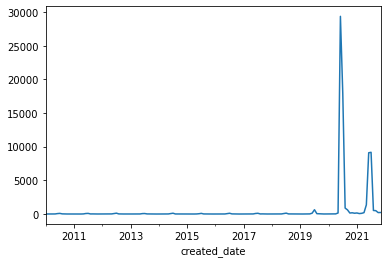

In [42]:
# Plot the monthly count of Illegal Fireworks complaint over time
fireworks = df[df.complaint_type == 'Illegal Fireworks']
fireworks.resample("M", on="created_date").size().plot()

In [43]:
# Plotting the size to get a closer look at those numbers
fireworks.resample("M", on="created_date").size()
# At this point I would copy this data and manually add, because I don't know the simplest way to add the specific months I'm interested in
# Summer = June, July and August
# Summer 2018 = 212 complaints
# Summer 2019 = 811 complaints
# Summer 2020 = 48,187 complaints

# Ideally I'd like to get the average complaints per summer per year prior to 2020

created_date
2010-01-31       3
2010-02-28       0
2010-03-31       2
2010-04-30       6
2010-05-31      10
              ... 
2021-07-31    9174
2021-08-31     527
2021-09-30     497
2021-10-31     214
2021-11-30     225
Freq: M, Length: 143, dtype: int64

In [ ]:
# My analysis assumes that:
# there is not someone maliciously hacking these numbers ie one person creating an insanely huge number of complaints. 
# there are no duplicates, triplicates, etc....
# firework complaints were not being filed in any other category than the Illegal Fireworks category

## Sanitation and work slowdowns

The Dept of Sanitation recently had a work slowdown to protest the vaccine mandate. You'd like to write about past work slowdowns that have caused garbage to pile up in the street, streets to not be swept, etc, and compare them to the current slowdown. You've also heard rumors that it was worse in Staten Island and a few Brooklyn neighborhoods - Marine Park and Canarsie - than everywhere else.

Use the data to find timeframes worth researching, and note how this slowdown might compare. Also, is there anything behind the geographic issue?

What assumptions is your analysis making? What could make your analysis fall apart?

In [48]:
#Looking at common complaint types to DSNY
# Let's just look at missed collection data over time
df[df.agency == "DSNY"].complaint_type.value_counts().head()

Dirty Conditions                       404734
Missed Collection (All Materials)      338542
Request Large Bulky Item Collection    326335
Sanitation Condition                   306280
Derelict Vehicles                      275218
Name: complaint_type, dtype: int64

<AxesSubplot:xlabel='created_date'>

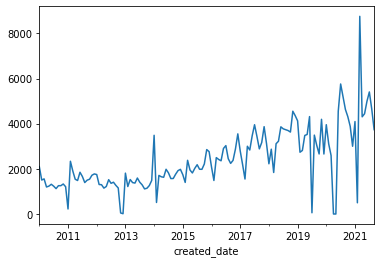

In [49]:
# Looks like we should look at a period in early 2021
df[df.complaint_type == "Missed Collection (All Materials)"].resample("M", on ="created_date").size().plot()

<AxesSubplot:xlabel='created_date'>

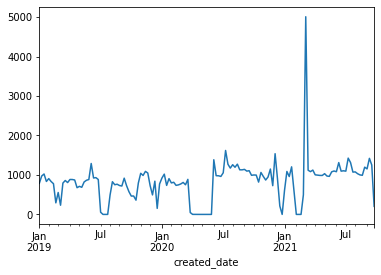

In [50]:
df[(df.created_date > '2019') & (df.complaint_type == 'Missed Collection (All Materials)')] \
    .resample('W', on='created_date').size() \
    .plot()

<AxesSubplot:xlabel='created_date'>

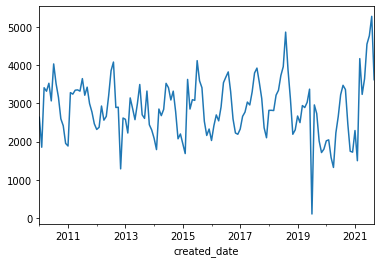

In [51]:
df[df.complaint_type == "Dirty Conditions"].resample("M", on ="created_date").size().plot()

<AxesSubplot:xlabel='created_date'>

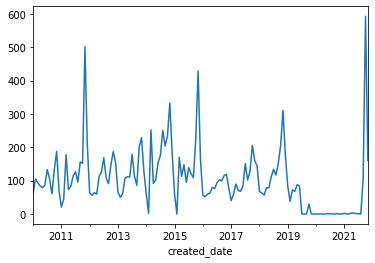

In [52]:
#Looks like a mid 2021 date range would be worth inspecting Re: Street Sweeping
df[df.complaint_type.str.contains("sweeping", case=False, na=False)].resample("M", on ="created_date").size().plot()

In [ ]:
# It would be worth inspecting previous spikes in complaints
# were they also due to labor shortages or strikes?
# My analysis would require me to go deeper into the descriptor column and to clean up the data more
# I would need to join this data-set with neighborhood-level dataset based on address
# There appear to be some stark drops which makes me wonder whether there were app outages during that period.

## NYCHA and public funds

NYC's public housing infrastructure is failing, and one reason is lack of federal funds. While the recent spending bills passed through Congress might be able to help, the feeling is that things have really fallen apart in the past however-many years – as time goes on it gets more and more difficult for the agency in control of things to address issues in a timely manner.

If you were tasked with finding information to help a reporter writing on this topic, you will **not** reasonably be able to find much in the dataset to support or refute this. Why not? 

If you wanted to squeeze something out of this dataset anyway, what could an option be? (You might need to bring in another dataset.)

In [53]:
# No complaint type specifically about NYCHA
df[df.complaint_type.str.contains("NYCHA", case=False, na=False)]

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,time_to_fix


In [54]:
# No descriptor type specifically about NYCHA
df[df.descriptor.str.contains("NYCHA", case=False, na=False)]

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,address_type,city,status,borough,open_data_channel_type,time_to_fix


In [55]:
df[df.agency == 'HPD'].location_type.value_counts()

RESIDENTIAL BUILDING    6702921
Residential Building       7098
Apartment                     5
Building-Wide                 4
Public Area                   2
Name: location_type, dtype: int64

<AxesSubplot:xlabel='created_date'>

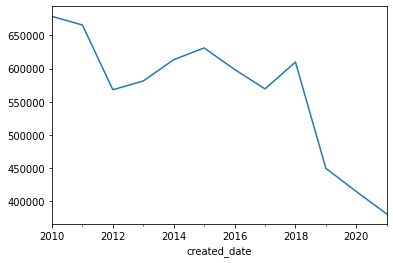

In [56]:
# One could look at HPD complaints at addresses that match NYCHA addresses (joining those two data sets)
# This would give a sense of how many complaints are coming in over time (would need to filter the data set to NYCHA locations)
df[df.agency == 'HPD'].resample("Y", on='created_date').size().sort_index().plot()

In [57]:
# Median Time_to_Fix by year. Seems to be improving? 
# Although it looks like these times were manually entered before 2016
df[df.agency == 'HPD'].resample("Y", on='created_date').time_to_fix.median()

created_date
2010-12-31          7 days 00:00:00
2011-12-31          5 days 00:00:00
2012-12-31          6 days 00:00:00
2013-12-31          6 days 00:00:00
2014-12-31          6 days 00:00:00
2015-12-31          6 days 00:00:00
2016-12-31          5 days 21:24:34
2017-12-31          5 days 20:49:42
2018-12-31          5 days 21:37:08
2019-12-31   3 days 22:47:53.500000
2020-12-31          4 days 16:47:23
2021-12-31          4 days 08:35:19
Freq: A-DEC, Name: time_to_fix, dtype: timedelta64[ns]